# <center> Cosine Similarity </center> 

In [1]:
from datasets import load_dataset

wikipedia = load_dataset('wikipedia', '20220301.en', split='train')
wikipedia.shuffle(seed=916)
subset = wikipedia.select(range(500))

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [2]:
from transformers import AutoTokenizer, AutoModel
from reduced_encoders.modeling_utils import SentencePooler

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-base-uncased', add_pooling_layer=False)
bert_reduced = AutoModel.from_pretrained('cayjobla/bert-base-uncased-reduced')

mpnet_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
mpnet = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2', add_pooling_layer=False)
mpnet_reduced = AutoModel.from_pretrained('cayjobla/all-mpnet-base-v2-reduced')
mpnet_compressed = AutoModel.from_pretrained('cayjobla/all-mpnet-base-v2-compressed')

In [3]:
import torch

def mean_pooling(hidden_states, attention_mask):
    mask = attention_mask.unsqueeze(-1)
    mask = mask.expand(hidden_states.size()).float()
    return torch.sum(hidden_states * mask, 1) / torch.sum(mask, 1)

def cls_pooling(hidden_states):
    return hidden_states[:, 0]

In [4]:
def encode(batch):
    text = batch['text']

    bert_inputs = bert_tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    bert_outputs = bert(**bert_inputs)
    bert_reduced_outputs = bert_reduced(**bert_inputs)

    mpnet_inputs = mpnet_tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    mpnet_outputs = mpnet(**mpnet_inputs)
    mpnet_reduced_outputs = mpnet_reduced(**mpnet_inputs)
    mpnet_compressed_outputs = mpnet_compressed(**mpnet_inputs)

    return {
        'bert': cls_pooling(bert_outputs.last_hidden_state),
        'bert_reduced': cls_pooling(bert_reduced_outputs.last_hidden_state),
        'mpnet': mean_pooling(mpnet_outputs.last_hidden_state, mpnet_inputs['attention_mask']),
        'mpnet_reduced': mpnet_reduced_outputs.pooler_output,
        'mpnet_compressed': mpnet_compressed_outputs.pooler_output
    }

In [5]:
embeddings = subset.map(encode, batched=True, batch_size=4, remove_columns=subset.column_names)
embeddings = embeddings.with_format('torch')

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [6]:
from reduced_encoders.modeling_utils import get_cos_sim

bert_similarity = get_cos_sim(embeddings['bert'])
bert_reduced_similarity = get_cos_sim(embeddings['bert_reduced'])
mpnet_similarity = get_cos_sim(embeddings['mpnet'])
mpnet_reduced_similarity = get_cos_sim(embeddings['mpnet_reduced'])
mpnet_compressed_similarity = get_cos_sim(embeddings['mpnet_compressed'])

In [7]:
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

def plot_distribution(dist, ax=None, density_color='C0', mean_color='C1', alpha=0.7, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(dist.numpy(), bins=100, color=density_color, alpha=alpha, density=True, label=label)
    ax.axvline(dist.mean().item(), color=mean_color, linestyle='dashed', linewidth=1)
    return ax

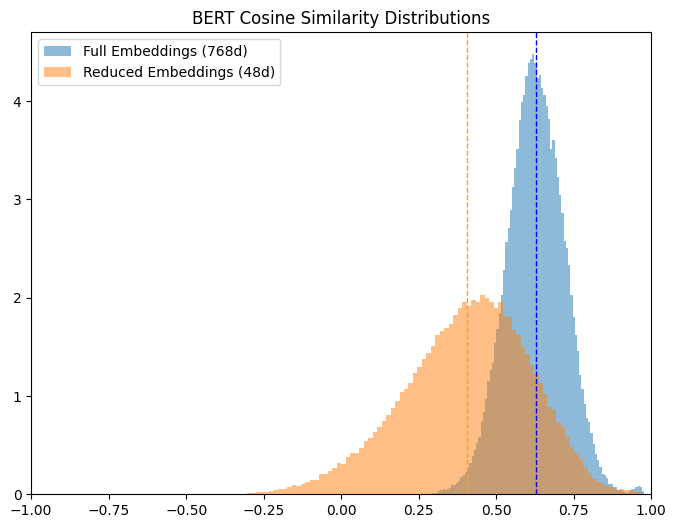

In [77]:
# Plot the BERT cosine similarity distributions
fig, ax = plt.subplots(figsize=(8,6))
ax = plot_distribution(bert_similarity, ax=ax, density_color="C0", mean_color="blue", label="Full Embeddings (768d)", alpha=0.5)
ax = plot_distribution(bert_reduced_similarity, ax=ax, density_color="C1", mean_color="orange", label="Reduced Embeddings (48d)", alpha=0.5)
ax.set_xlim(-1,1)
ax.set_title("BERT Cosine Similarity Distributions")
plt.legend()
plt.show()

In [72]:
from torch.nn.functional import mse_loss
from scipy.stats import wasserstein_distance

print("BERT vs. ReducedBERT:")
print("DDL\t\t\t", mse_loss(bert_similarity, bert_reduced_similarity).item())
print("Earthmover distance\t", wasserstein_distance(bert_similarity.numpy(), bert_reduced_similarity.numpy()))

BERT vs. ReducedBERT:
DDL			 0.08001872152090073
Earthmover distance	 0.22154307198357337


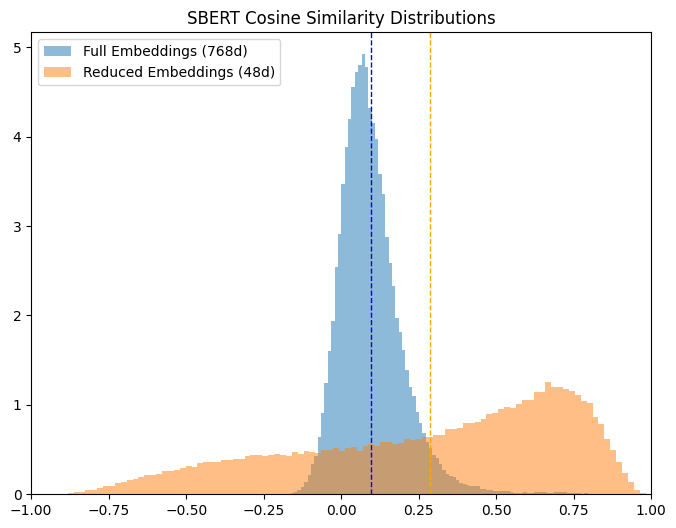

In [73]:
# Plot the MPNET cosine similarity distributions
fig, ax = plt.subplots(figsize=(8,6))
ax = plot_distribution(mpnet_similarity, ax=ax, density_color="C0", mean_color="blue", label="Full Embeddings (768d)", alpha=0.5)  # Mean Pooling
ax = plot_distribution(mpnet_reduced_similarity, ax=ax, density_color="C1", mean_color="orange", label="Reduced Embeddings (48d)", alpha=0.5)  # Mean Pooling
ax.set_xlim(-1,1)
ax.set_title("SBERT Cosine Similarity Distributions")
plt.legend()
plt.show()

In [74]:
from torch.nn.functional import mse_loss
from scipy.stats import wasserstein_distance

print("SBERT vs. ReducedSBERT:")
print("DDL\t\t\t", mse_loss(mpnet_similarity, mpnet_reduced_similarity).item())
print("Earthmover distance\t", wasserstein_distance(mpnet_similarity.numpy(), mpnet_reduced_similarity.numpy()))

SBERT vs. ReducedSBERT:
DDL			 0.2233923375606537
Earthmover distance	 0.3538343602376852


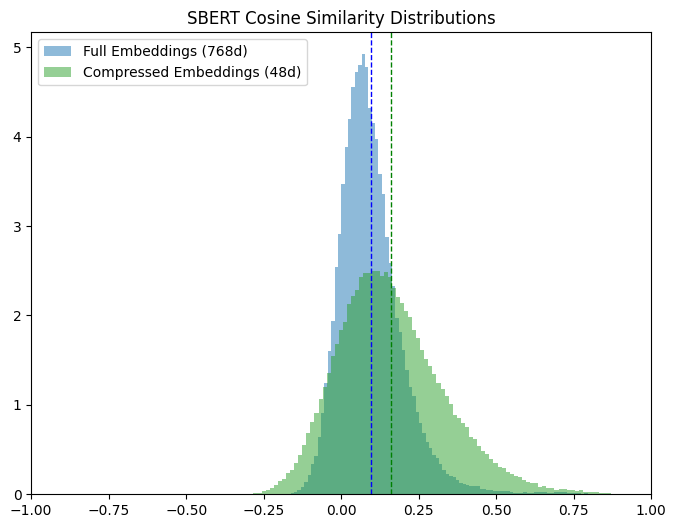

In [11]:
# Plot the MPNET cosine similarity distributions (with compressed)
fig, ax = plt.subplots(figsize=(8,6))
ax = plot_distribution(mpnet_similarity, ax=ax, density_color="C0", mean_color="blue", label="Full Embeddings (768d)", alpha=0.5)
ax = plot_distribution(mpnet_compressed_similarity, ax=ax, density_color="C2", mean_color="green", label="Compressed Embeddings (48d)", alpha=0.5)
ax.set_xlim(-1,1)
ax.set_title("SBERT Cosine Similarity Distributions")
plt.legend()
plt.show()

In [12]:
from torch.nn.functional import mse_loss
from scipy.stats import wasserstein_distance

print("SBERT vs. CompresSBERT:")
print("DDL\t\t\t", mse_loss(mpnet_similarity, mpnet_compressed_similarity).item())
print("Earthmover distance\t", wasserstein_distance(mpnet_similarity.numpy(), mpnet_compressed_similarity.numpy()))
print("Earthmover distance 2\t", wasserstein_distance(mpnet_compressed_similarity.numpy(), mpnet_similarity.numpy()))

SBERT vs. CompresSBERT:
DDL			 0.014109115116298199
Earthmover distance	 0.07804661612512281
Earthmover distance 2	 0.07804661612512281


# 768 dimensions (full size)

## 48 dimensions (BertReducedModel)

Note that the wikipedia sentence embeddings were done by an MPNet model, not a BERT model, so this distribution may not actually be informative

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

In [7]:
from reduced_encoders import BertReducedModel

reduce = BertReducedModel.from_pretrained('cayjobla/bert-base-uncased-reduced').reduce
reduce.to(device)

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DimReduce(
  (0): DimReshape(
    (linear): Linear(in_features=768, out_features=512, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): DimReshape(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (2): DimReshape(
    (linear): Linear(in_features=256, out_features=128, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (3): DimReshape(
    (linear): Linear(in_features=128, out_features=64, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (4): DimReshape(
    (linear): Linear(in_features=64, out_features=48, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [8]:
sample1 = sample1.to(device)
reduced_sample1 = reduce(sample1).detach().cpu()
sample1 = sample1.cpu()

sample2 = sample2.to(device)
reduced_sample2 = reduce(sample2).detach().cpu()
sample2 = sample2.cpu()

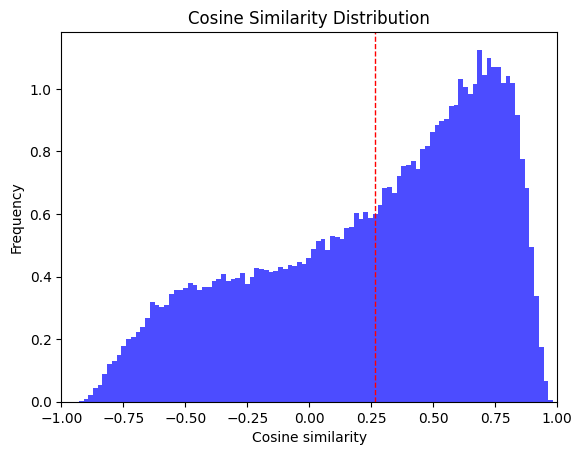

In [9]:
reduced_bert_dist = plot_similarity_distribution(reduced_sample1, reduced_sample2)

## 48 dimensions (MPNetReduced)

In [10]:
from reduced_encoders import MPNetReducedModel

reduce = MPNetReducedModel.from_pretrained('cayjobla/all-mpnet-base-v2-reduced').reduce
reduce.to(device)

DimReduce(
  (0): DimReshape(
    (linear): Linear(in_features=768, out_features=512, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): DimReshape(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (2): DimReshape(
    (linear): Linear(in_features=256, out_features=128, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (3): DimReshape(
    (linear): Linear(in_features=128, out_features=64, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (4): DimReshape(
    (linear): Linear(in_features=64, out_features=48, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [11]:
sample1 = sample1.to(device)
reduced_sample1 = reduce(sample1).detach().cpu()
sample1 = sample1.cpu()

sample2 = sample2.to(device)
reduced_sample2 = reduce(sample2).detach().cpu()
sample2 = sample2.cpu()

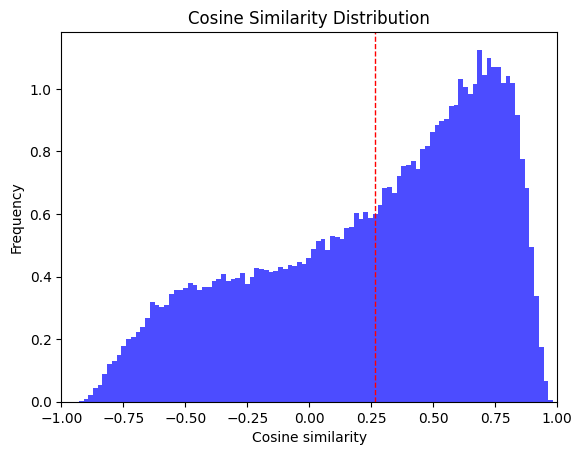

In [12]:
reduced_mpnet_dist = plot_similarity_distribution(reduced_sample1, reduced_sample2)

This is consistent with the ReducedBert model

## 48 dimensions (MPNetCompressed)

Now we can look at what the cosine similarities look like on a model that was trained on them

In [13]:
from reduced_encoders import MPNetCompressedModel

reduce = MPNetCompressedModel.from_pretrained('cayjobla/all-mpnet-base-v2-compressed').reduce
reduce.to(device)

DimReduce(
  (0): DimReshape(
    (linear): Linear(in_features=768, out_features=512, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): DimReshape(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (2): DimReshape(
    (linear): Linear(in_features=256, out_features=128, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (3): DimReshape(
    (linear): Linear(in_features=128, out_features=64, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (4): DimReshape(
    (linear): Linear(in_features=64, out_features=48, bias=True)
    (activation): GELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [14]:
sample1 = sample1.to(device)
reduced_sample1 = reduce(sample1).detach().cpu()
sample1 = sample1.cpu()

sample2 = sample2.to(device)
reduced_sample2 = reduce(sample2).detach().cpu()
sample2 = sample2.cpu()

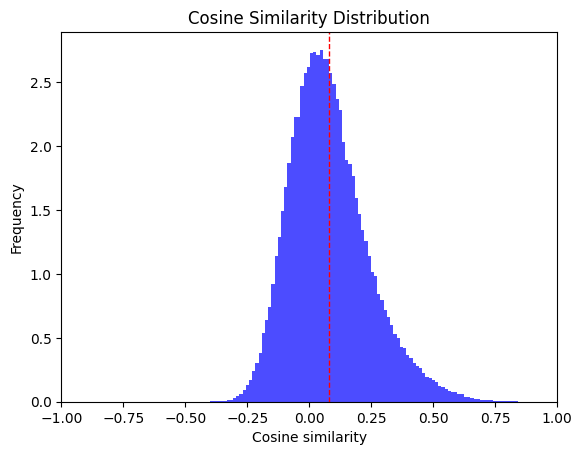

In [15]:
compressed_mpnet_dist = plot_similarity_distribution(reduced_sample1, reduced_sample2)

## Comparison

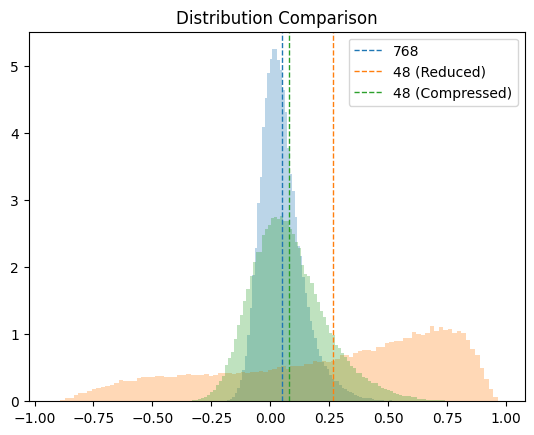

In [16]:
ax = plot_distribution(full_dist, density_color="C0", mean_color="C0", alpha=0.3)
ax = plot_distribution(reduced_mpnet_dist, density_color="C1", mean_color="C1", alpha=0.3, ax=ax)
ax = plot_distribution(compressed_mpnet_dist, density_color="C2", mean_color="C2", alpha=0.3, ax=ax)
ax.legend(["768", "48 (Reduced)", "48 (Compressed)"])
ax.set_title("Distribution Comparison")
plt.show()

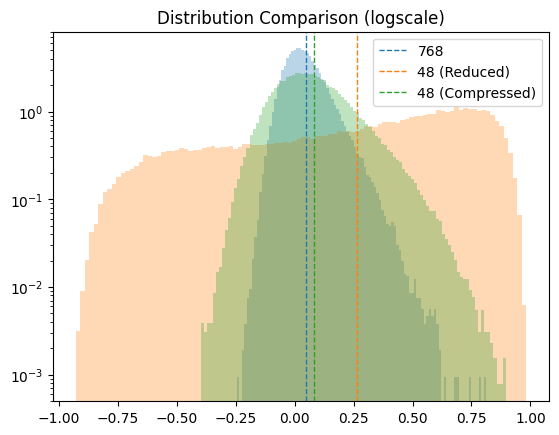

In [17]:
ax = plot_distribution(full_dist, density_color="C0", mean_color="C0", alpha=0.3)
ax = plot_distribution(reduced_mpnet_dist, density_color="C1", mean_color="C1", alpha=0.3, ax=ax)
ax = plot_distribution(compressed_mpnet_dist, density_color="C2", mean_color="C2", alpha=0.3, ax=ax)
ax.legend(["768", "48 (Reduced)", "48 (Compressed)"])
ax.set_title("Distribution Comparison (logscale)")
ax.set_yscale("log")
plt.show()

Evidently, training the reduction as a compressed model has a fairly large effect on the distribution of cosine similarities that are output by pairs of elements. Maybe I should look into combatting this through some sort of normalzation before the cosine similarities are compared in the compressed model.

## Normalization

In [18]:
import torch

def normalize(dist):
    mu = torch.mean(dist)
    std = torch.std(dist)
    return (dist - mu) / std

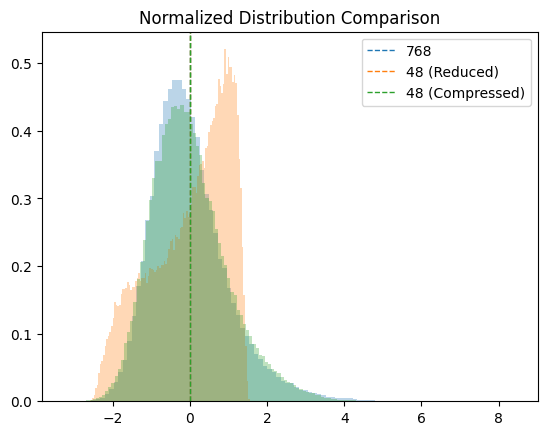

In [19]:
ax = plot_distribution(normalize(full_dist), density_color="C0", mean_color="C0", alpha=0.3)
ax = plot_distribution(normalize(reduced_mpnet_dist), density_color="C1", mean_color="C1", alpha=0.3, ax=ax)
ax = plot_distribution(normalize(compressed_mpnet_dist), density_color="C2", mean_color="C2", alpha=0.3, ax=ax)
ax.legend(["768", "48 (Reduced)", "48 (Compressed)"])
ax.set_title("Normalized Distribution Comparison")
plt.show()

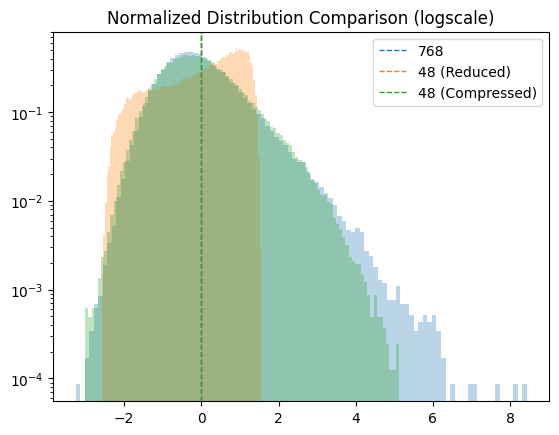

In [20]:
ax = plot_distribution(normalize(full_dist), density_color="C0", mean_color="C0", alpha=0.3)
ax = plot_distribution(normalize(reduced_mpnet_dist), density_color="C1", mean_color="C1", alpha=0.3, ax=ax)
ax = plot_distribution(normalize(compressed_mpnet_dist), density_color="C2", mean_color="C2", alpha=0.3, ax=ax)
ax.legend(["768", "48 (Reduced)", "48 (Compressed)"])
ax.set_title("Normalized Distribution Comparison (logscale)")
ax.set_yscale("log")
plt.show()